In [12]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

import IPython.display as disp
from PIL import Image
from torchvision.models import vgg19
from torch.autograd import Variable
from collections import OrderedDict
IMAGE_SIZE = 512

In [13]:
#предобработка изображений(нормализация c параметрами для VGG)
preprocessing = transforms.Compose(
    [transforms.Resize(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]), 
     transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1]),
     transforms.Lambda(lambda x: x.mul_(255)),
    ])

postprocessing = transforms.Compose(
    [transforms.Lambda(lambda x: x.clone()[0].squeeze()),
     transforms.Lambda(lambda x: x.mul_(1./255)),
     transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]),
     transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
     transforms.Lambda(lambda x: x.data.clamp(0, 1)),
     transforms.ToPILImage()   
    ])

def loader(image_name):
    image = Image.open(image_name)
    image = preprocessing(image).unsqueeze(0)
    return image

In [15]:
#с помощью register_forward_hook получаем лоссы нужных слоев, для вычисления style и content loss
class LayerActivations():
    features=[]
    def __init__(self,model,layer_nums):
        self.hooks = []
        for layer_num in layer_nums:
            self.hooks.append(model[layer_num].register_forward_hook(self.hook_fn))
    
    def hook_fn(self, module, input, output):
        self.features.append(output)
        
    def remove(self):
        for hook in self.hooks:
            hook.remove()
            
def gram_matrix(x):
    Nx, Cx, Hx, Wx = x.size()  
    features = x.view(Nx, Cx, Hx * Wx) 
    G = torch.bmm(features, features.transpose(1,2))
    G = G.div(Hx * Wx)
    return G
        
class StyleLoss(nn.Module):    
    def forward(self, inputs, targets):
        return F.mse_loss(gram_matrix(inputs), targets)
    
class ContentLoss(nn.Module):
    def forward(self, inputs, targets):
        return F.mse_loss(inputs, targets)

In [14]:
content_img_path = 'venice.jpg'
style_img_path = 'afremov.jpg'

#параметры слоев
style_layers = {"layer_nums": [1, 6, 11, 20, 25],
                "layer_weight": [1e3/n**2 for n in [64, 128, 256, 512, 512]], 
                "n": 5}
content_layers = {"layer_nums": [21],
                  "layer_weight":[1],
                  "n": 1}

In [7]:
class NeuralStyle:
    def __init__(self, cnn=vgg19, content_img_path=content_img_path, style_img_path=style_img_path,
                 style_layers=style_layers, content_layers=content_layers):

        self.cnn = cnn(pretrained=True).features.eval()

        self.style_image = loader(style_img_path)
        self.content_image = loader(content_img_path)

        self.output_image = Variable(self.content_image.data.clone(), requires_grad=True)
        self.optimizer = optim.LBFGS([self.output_image])
        self.layers_num = style_layers["layer_nums"] + content_layers["layer_nums"]
        self.layers_weigh = style_layers["layer_weight"] + content_layers["layer_weight"]
        self.loss = [StyleLoss()] * style_layers["n"] + [ContentLoss()] * content_layers["n"]
        self.content_layers = [x.detach() for x in self.extract(content_layers["layer_nums"], self.content_image)]
        self.style_layers = [gram_matrix(x).detach() for x in self.extract(style_layers["layer_nums"], self.style_image)]
        self.layers = self.style_layers + self.content_layers
        self.loss_hist = []

    def extract(self, layers, image):
        la = LayerActivations(self.cnn, layers)
        la.features = []
        out = self.cnn(image)
        la.remove()
        return la.features


    def run(self, max_iters=300, print_iters=50, picture=True):
        iters = 0
        while iters < max_iters:
            
            def closure():
                nonlocal iters
                self.optimizer.zero_grad()

                out = self.extract(self.layers_num, self.output_image)
                Loss = np.sum([self.layers_weigh[i] * self.loss[i](x, self.layers[i]) for i, x in enumerate(out)])
                Loss.backward()
                self.loss_hist.append(Loss)
                iters += 1
                if iters % print_iters == 0:
                    print(f'Iter: {iters} Loss: {Loss.item()}')
                return Loss

            self.optimizer.step(closure)


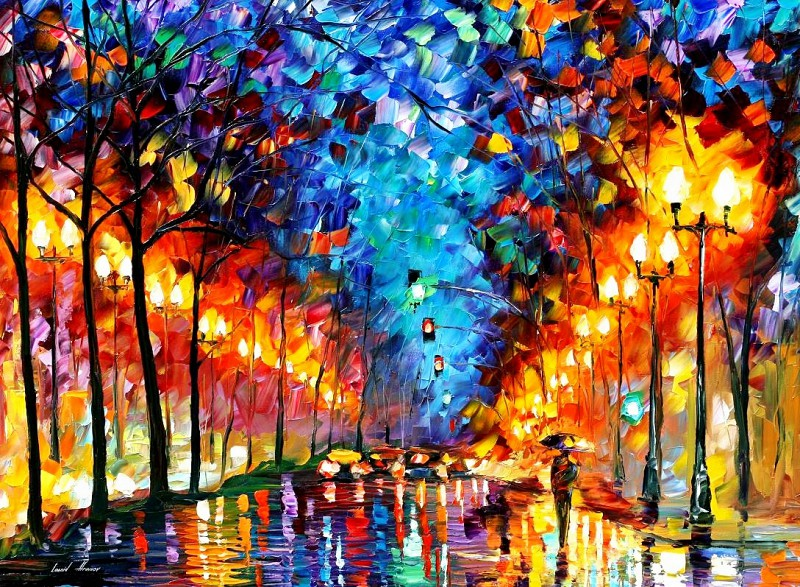

In [8]:
disp.Image(style_img_path)

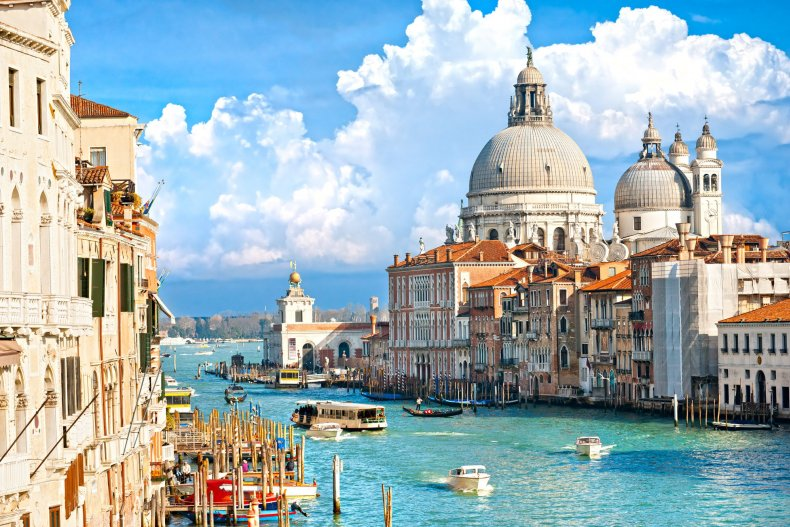

In [9]:
disp.Image(content_img_path)

In [10]:
model = NeuralStyle()
#обучение
model.run()

Iter: 50 Loss: 96557.9296875
Iter: 100 Loss: 47381.19140625
Iter: 150 Loss: 37530.62109375
Iter: 200 Loss: 33847.3203125
Iter: 250 Loss: 31903.67578125
Iter: 300 Loss: 30718.7734375


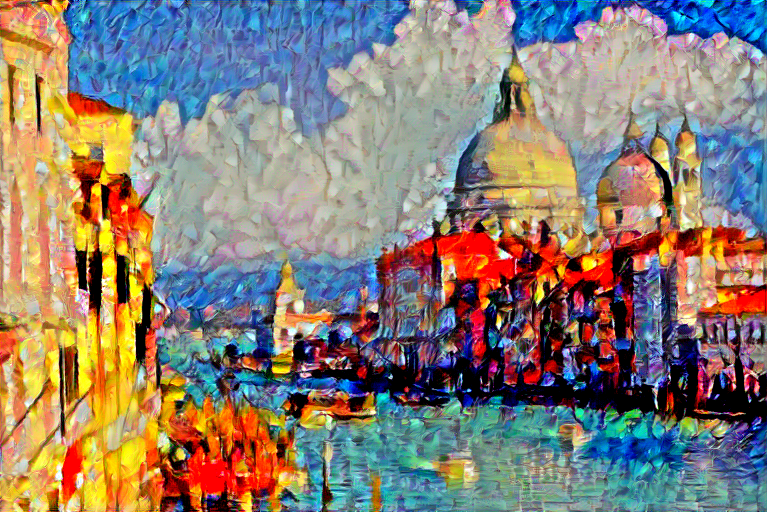

In [11]:
postprocessing(model.output_image.data)